# Mod 4

## Intro

In the following notebook we will be uncovering information from a dataset. Particularly, we will be creating a model which explores the likely hood of a tweet being associated with a specific emotion. To do this we will be walking through two classification models. The data we will be reviewing provides us with tweets and an emotional response towards that current tweet. What we explore throughout this is, which words associate most commonly with that emotion. We also need to understand their importance / frequency. E.g. Does incredible associate more with negative, positive or neutral emotions.



## Imports

In [83]:
import pandas as pd
import numpy as np
import pandas as pd
import sklearn.metrics as metrics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, recall_score
from xgboost import XGBRFClassifier,XGBClassifier
import shap
from imblearn.over_sampling import SMOTE
shap.initjs()
import warnings
from collections import Counter
from nltk import FreqDist
import nltk
# nltk.download('punkt')
from nltk import word_tokenize

from wordcloud import WordCloud

warnings.filterwarnings('ignore')

In [84]:
from nltk.corpus import stopwords
# nltk.download('stopwords')
import string

In [85]:
df = pd.read_csv('judge-1377884607_tweet_product_company.csv',
                 encoding = 'latin1')

## Cleaning

In [86]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [87]:
df.columns = ['tweet','product_mentioned','emotion']
df.head()

,tweet,product_mentioned,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [88]:
df['emotion'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

In [89]:
df['product_mentioned'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product_mentioned, dtype: int64

In [90]:
df.isna().sum()

tweet                   1
product_mentioned    5802
emotion                 0
dtype: int64

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   tweet              9092 non-null   object
 1   product_mentioned  3291 non-null   object
 2   emotion            9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [92]:
df.loc[df.isnull().any(axis=1)]

,tweet,product_mentioned,emotion
5,@teachntech00 New iPad Apps For #SpeechTherapy...,NaN,No emotion toward brand or product
6,NaN,NaN,No emotion toward brand or product
16,Holler Gram for iPad on the iTunes App Store -...,NaN,No emotion toward brand or product
32,"Attn: All #SXSW frineds, @mention Register fo...",NaN,No emotion toward brand or product
33,Anyone at #sxsw want to sell their old iPad?,NaN,No emotion toward brand or product
...,...,...,...
9087,"@mention Yup, but I don't have a third app yet...",NaN,No emotion toward brand or product
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


Removing product mentioned column as it's easy to associate the emotion towards a tweet about a company / product. E.g. this iphone is great!

In [93]:
#Removing product mentioned since we're trying to achieve emotion towards a tweet

df = df.drop(['product_mentioned'], axis = 1)

In [94]:
df.isna().sum()

tweet      1
emotion    0
dtype: int64

In [95]:
df.loc[df.isnull().any(axis=1)]

,tweet,emotion
6,NaN,No emotion toward brand or product


In [96]:
#Removing the one null value
df = df.dropna(how='any',axis=0) 

In [97]:
df.isna().sum()

tweet      0
emotion    0
dtype: int64

## Exploring the Text

Now that everything is clean I need to create my list of text, which will be known as corpus.

In [98]:
corpus = df['tweet'].to_list()

In [99]:
# First 5 tweets
corpus[:5]

['.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 "@jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW",
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw",
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"]

### Frequency Distribution and Tokenization

Next, we need to find our frequency distribution from our corpus

In [100]:
freq = FreqDist('.'.join(corpus))

#Let's now look at the top 50 words

freq.most_common(50)

[(' ', 153873),
 ('e', 72593),
 ('o', 62850),
 ('n', 56651),
 ('t', 55549),
 ('i', 51978),
 ('a', 46024),
 ('s', 43823),
 ('r', 31903),
 ('l', 30420),
 ('h', 21549),
 ('p', 21506),
 ('d', 20073),
 ('m', 19206),
 ('u', 18363),
 ('.', 17473),
 ('w', 15979),
 ('#', 15875),
 ('g', 15602),
 ('c', 14950),
 ('S', 13550),
 ('y', 11753),
 ('k', 10404),
 ('f', 9839),
 ('b', 7514),
 ('@', 7194),
 ('W', 6831),
 ('x', 6460),
 ('T', 5977),
 ('P', 5701),
 ('A', 5597),
 ('v', 5258),
 ('X', 5211),
 ('}', 4298),
 ('{', 4296),
 ('R', 3865),
 ('G', 3585),
 (',', 3558),
 ('I', 2982),
 ("'", 2903),
 (';', 2800),
 ('&', 2707),
 ('C', 2689),
 ('-', 2438),
 ('M', 2412),
 ('!', 2398),
 (':', 2310),
 ('2', 2213),
 ('q', 2098),
 ('N', 1898)]

I forgot to tokenize the above. Meaning that what we just solved for was the number of times a character appeared rather than a word. Which is not what I Wanted.

In [101]:
token = word_tokenize('.'.join(corpus))

freq = FreqDist(token)

freq.most_common(50)

[('#', 15875),
 ('@', 7194),
 ('mention', 6745),
 ('.', 5785),
 ('link', 4311),
 ('}', 4298),
 ('{', 4296),
 ('the', 3914),
 ('SXSW', 3850),
 (',', 3533),
 ('to', 3519),
 ('at', 2858),
 (';', 2800),
 ('sxsw', 2798),
 ('&', 2707),
 ('for', 2439),
 ('!', 2398),
 ('a', 2171),
 (':', 2075),
 ('iPad', 2051),
 ('in', 1818),
 ('Google', 1760),
 ('quot', 1696),
 ('of', 1690),
 ('Apple', 1663),
 ('?', 1659),
 ('is', 1639),
 ('and', 1524),
 ('on', 1269),
 ('iPhone', 1262),
 ("'s", 1230),
 ('I', 1187),
 ('2', 1103),
 ('store', 1038),
 ('-', 972),
 ('RT', 958),
 ('you', 941),
 ('Austin', 886),
 ('an', 853),
 ('amp', 836),
 ('with', 804),
 (')', 801),
 ('up', 778),
 ('(', 770),
 ('it', 755),
 ('my', 705),
 ('.RT', 668),
 ('...', 649),
 ('app', 623),
 ('Circles', 578)]

As we can see, we're still running into issues here. I need to remove special characters or instances where there are uses of apostrophes that are separating characters from words still. These are what we call stop words and next we have to create a "stopword" list on top of the one I've already imported for special instances.

In [102]:
stopwords_ls = stopwords.words('english')
stopwords_ls[:25]

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers']

Great, now that this is complete we can add punctuation to the "stopword" list from where I imported "string".

In [103]:
stopwords_ls.extend(string.punctuation)
stopwords_ls[-5:]

['`', '{', '|', '}', '~']

Tweets are annoying in that there are special punctuation marks like "..." or '"' and they are counted as characters. Just to make sure we don't run into any of these issues we're going to add them to our "stopword" list for, hopefully, our complete "stopword" list.

In [104]:
twitter_punc = ['"', '...', "' '",'sxsw','sxsw.rt','sxswi',]
stopwords_ls.extend(twitter_punc)
stopwords_ls[-5:]

['...', "' '", 'sxsw', 'sxsw.rt', 'sxswi']

In [105]:
# Removing my stopwords from my list
removed_tokens = [w.lower() for w in token if w.lower() not in stopwords_ls]
removed_tokens[:25]

['wesley83',
 '3g',
 'iphone',
 '3',
 'hrs',
 'tweeting',
 'rise_austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'stations',
 'sxsw..',
 'jessedee',
 'know',
 'fludapp',
 'awesome',
 'ipad/iphone',
 'app',
 "'ll",
 'likely',
 'appreciate',
 'design',
 'also',
 "'re"]

In [106]:
freq = FreqDist(removed_tokens)
freq.most_common(50)

[('mention', 6746),
 ('link', 4313),
 ('ipad', 2330),
 ('google', 2188),
 ('apple', 2046),
 ('quot', 1696),
 ('iphone', 1462),
 ('store', 1459),
 ("'s", 1234),
 ('2', 1103),
 ('new', 1045),
 ('rt', 970),
 ('austin', 936),
 ('amp', 836),
 ('app', 802),
 ('.rt', 669),
 ('launch', 650),
 ('social', 640),
 ('circles', 630),
 ('today', 565),
 ('android', 556),
 ("n't", 481),
 ('network', 463),
 ('pop-up', 413),
 ('via', 411),
 ('ipad2', 377),
 ('line', 377),
 ('get', 369),
 ('called', 361),
 ('free', 356),
 ('party', 342),
 ('mobile', 326),
 ('major', 300),
 ('one', 292),
 ('like', 282),
 ("'re", 265),
 ('time', 265),
 ('opening', 256),
 ("'m", 254),
 ('temporary', 253),
 ('possibly', 240),
 ('downtown', 225),
 ('people', 220),
 ('apps', 218),
 ('maps', 218),
 ('see', 213),
 ('open', 209),
 ('day', 207),
 ('popup', 206),
 ('going', 203)]

I'm now wondering why sxsw populates so much here. This is an event not associated with apple or android. After revealing the below information, we can see that people were trying to scalp in some instances. Regardless. sxsw or any affiliates of it are not important in terms of identifying if a tweet is positive or negative. So I chose to add this as a stop word back in cell 39.

In [107]:
display(df.iloc[32])

tweet      Anyone at  #sxsw want to sell their old iPad?
emotion               No emotion toward brand or product
Name: 33, dtype: object

### WordCloud

Now to visualize this I want to just blow it up on a wordcloud. This wil help give us a representation of how important a word is based on it's size. The bigger it is the more times it was used in a tweet.

(-0.5, 399.5, 199.5, -0.5)

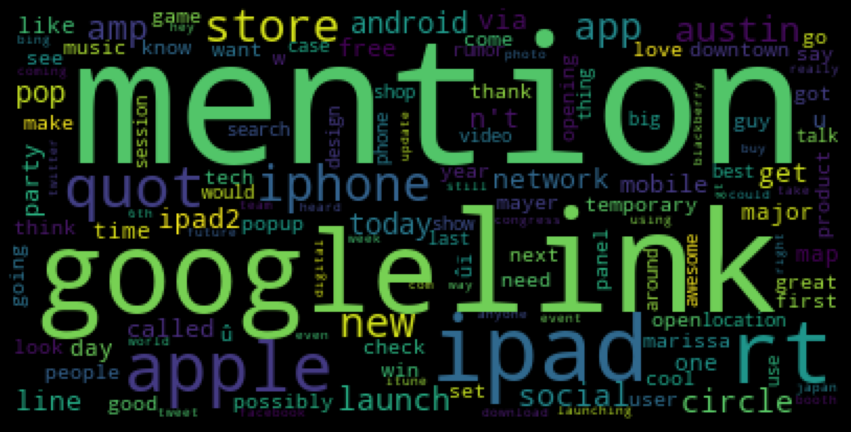

In [108]:
wordcloud = WordCloud(stopwords=stopwords_ls, collocations=False)
wordcloud.generate(','.join(removed_tokens))

plt.figure(figsize = (15,15), facecolor = 'black')
plt.imshow(wordcloud)
plt.axis('off')

### Bigram

Another interesting way I want to look at this information is buy looking at the repetition of words together. E.g. 'My home' or 'bad product'. This could help us further understand our text.

In [109]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tweet = nltk.BigramCollocationFinder.from_words(removed_tokens)
tweets_freq = tweet.score_ngrams(bigram_measures.raw_freq)

#### QUESTION
Should I reevaluate the rt and mentions?

In [110]:
#Put it into a dataframe
pd.DataFrame(tweets_freq, columns=["Word","Freq"]).head(20)

,Word,Freq
0,"(rt, mention)",0.008641
1,"(ipad, 2)",0.008413
2,"(.rt, mention)",0.006329
3,"(mention, mention)",0.005862
4,"(apple, store)",0.005349
5,"(link, .rt)",0.004597
6,"(mention, google)",0.004435
7,"(social, network)",0.004302
8,"(new, social)",0.003930
9,"(link, mention)",0.003131


### Exploring the URLS, Hashtags and @Mentions

In [111]:
# functions specific to tweets

import re

# def find_urls(string):
#     return re.findall(r"(http[s]?://\w*\.\w*/+\w+)", freq(string)

def find_urls(string):
    templist =  re.findall(r"(http[s]?://\w*\.\w*/+\w+)",string)
    wordcloud.generate(','.join(templist))

    plt.figure(figsize = (15,15), facecolor = 'black')
    plt.imshow(wordcloud)
    plt.axis('off')
    
    return nltk.FreqDist(templist)
    
def find_hashtags(string):
    templist =  re.findall(r'\#\w*',string)
    wordcloud.generate(','.join(templist))

    plt.figure(figsize = (15,15), facecolor = 'black')
    plt.imshow(wordcloud)
    plt.axis('off')
    
    return nltk.FreqDist(templist)

def find_retweets(string):
    templist = re.findall(r'RT [@]?\w*:',string)
    wordcloud.generate(','.join(templist))

    plt.figure(figsize = (15,15), facecolor = 'black')
    plt.imshow(wordcloud)
    plt.axis('off')
    
    return nltk.FreqDist(templist)

def find_mentions(string):
    templist = re.findall(r'\@\w*',string)
    wordcloud.generate(','.join(templist))

    plt.figure(figsize = (15,15), facecolor = 'black')
    plt.imshow(wordcloud)
    plt.axis('off')
    
    return nltk.FreqDist(templist)

In [112]:
all_words = '.'.join(corpus)

FreqDist({'http://bit.ly/hTdFim': 2, 'http://bit.ly/guardianapp': 2, 'http://ht.ly/49n4M': 1, 'http://bit.ly/ieaVOB': 1, 'http://bit.ly/gVLrIn': 1, 'http://j.mp/grN7pK': 1, 'http://bit.ly/aXZwxB': 1, 'http://tinyurl.com/4nqv92l': 1, 'http://t.co/kfN3f5Q': 1, 'http://t.co/g4GZypV': 1, ...})

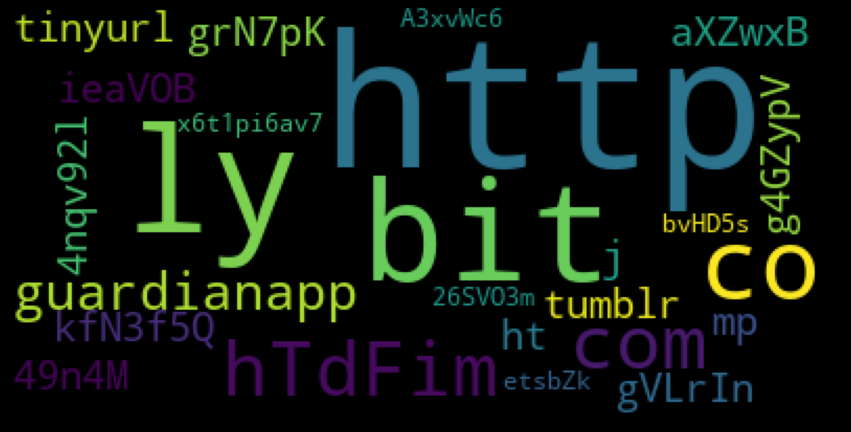

In [113]:
find_urls(all_words)

FreqDist({'#sxsw': 4544, '#SXSW': 4374, '#Apple': 245, '#iPhone': 215, '#sxswi': 209, '#iPad': 185, '#google': 177, '#apple': 171, '#iPad2': 154, '#SxSW': 154, ...})

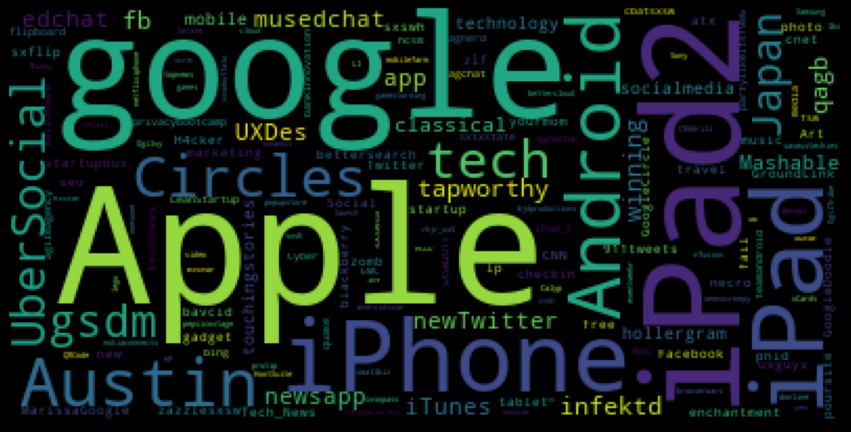

In [114]:
find_hashtags(all_words)

FreqDist({'RT @malbonster:': 1, 'RT @LaurieShook:': 1, 'RT UberSoc:': 1, 'RT SteveCase:': 1, 'RT NicoRiccelli:': 1, 'RT VentureBeat:': 1})

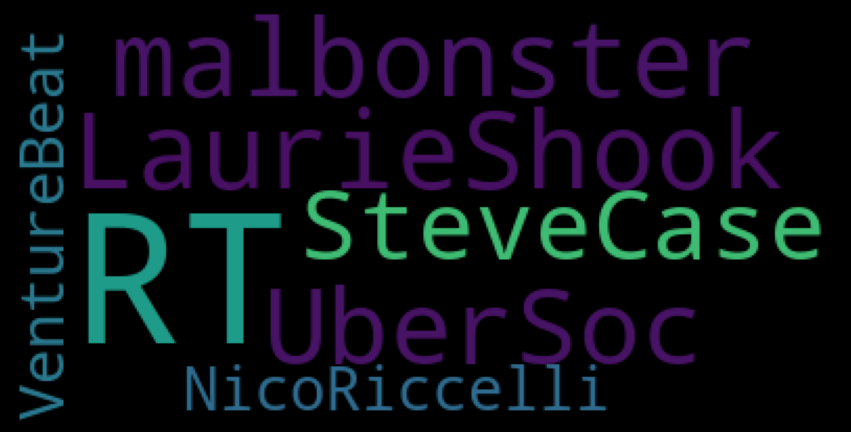

In [115]:
find_retweets(all_words)

FreqDist({'@mention': 7110, '@madebymany': 5, '@garyvee': 3, '@Schmittastic': 3, '@jerranalley': 2, '@tbalinas': 2, '@mentionc': 2, '@': 2, '@mentione': 2, '@mentionR': 2, ...})

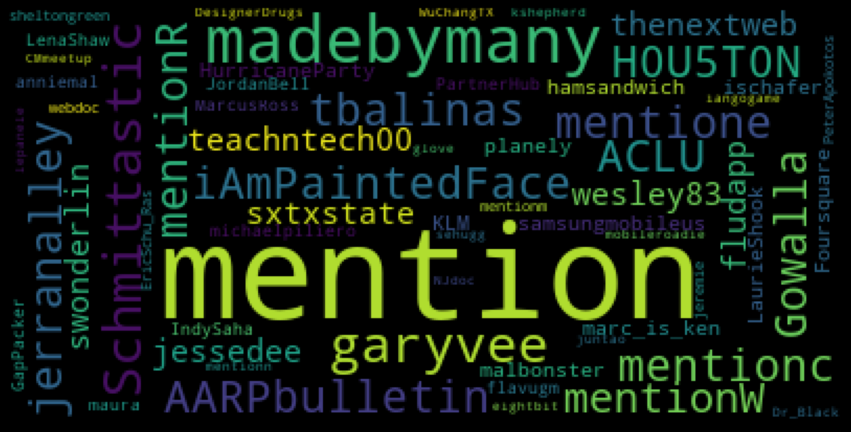

In [116]:
find_mentions(all_words)

# Back to the Dataframe

Now that I've explored some of the data. It's time to dig into the tweets themselves and identify if they're positive or negative. Throughout this we will then begin to build a model which should help us better learn these tweets.

In [117]:
df.head()

,tweet,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion


In [118]:
#reviewing my df again
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: emotion, dtype: int64

156 rows of "I can't tell" isn't much of my data set, so I'm going to remove them.

In [119]:
#removing I can't tell string from emotion column
df = df[~df['emotion'].str.contains("I can't tell")]
df['emotion'].value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
Name: emotion, dtype: int64

## Dealing with no Emotion

I need to understand what's going on in the tweets where there is no emotion towards a brand or product.

In [120]:
tweet = df[df['emotion']=='No emotion toward brand or product'].index
print(df.loc[tweet,'tweet'])

5       @teachntech00 New iPad Apps For #SpeechTherapy...
16      Holler Gram for iPad on the iTunes App Store -...
32      Attn: All  #SXSW frineds, @mention Register fo...
33          Anyone at  #sxsw want to sell their old iPad?
34      Anyone at  #SXSW who bought the new iPad want ...
                              ...                        
9087    @mention Yup, but I don't have a third app yet...
9089    Wave, buzz... RT @mention We interrupt your re...
9090    Google's Zeiger, a physician never reported po...
9091    Some Verizon iPhone customers complained their...
9092    Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...
Name: tweet, Length: 5388, dtype: object


After reviewing some of the above tweets, I can come to the determination that these tweets are majority 'neutral' and I'm going to treat them as such moving forward.

In [121]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8936 entries, 0 to 9092
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   tweet    8936 non-null   object
 1   emotion  8936 non-null   object
dtypes: object(2)
memory usage: 529.4+ KB


## Train Test Split

In [122]:
##scikit learn not designed for dummies
#label encode instead

In [123]:
from sklearn.preprocessing import LabelEncoder

In [124]:
## Initialiae label encoder
le = LabelEncoder()
df['emotions_cat'] = le.fit_transform(df['emotion'])
df.head()

,tweet,emotion,emotions_cat
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,Negative emotion,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,Positive emotion,2
2,@swonderlin Can not wait for #iPad 2 also. The...,Positive emotion,2
3,@sxsw I hope this year's festival isn't as cra...,Negative emotion,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Positive emotion,2


In [125]:
## Set y and x labels

y = df['emotions_cat']
X = df['tweet']

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.30,
                                                    random_state=10)

In [127]:
tokenizer = nltk.TweetTokenizer(preserve_case=False)
tokenizer

In [128]:
# std_scale = StandardScaler()

# X_train_scaled = std_scale.fit_transform(X_train)
# X_train_scaled = pd.DataFrame(X_train_scaled, columns = X.columns)
# X_test_scaled = std_scale.transform(X_test)
# X_test_scaled = pd.DataFrame(X_test_scaled, columns = X.columns)

In [129]:
from sklearn.feature_extraction.text import TfidfVectorizer


## Initialize TfIdf Vectorizer, feed in function of tokenize
vectorizer = TfidfVectorizer(tokenizer=tokenizer.tokenize,
                            stop_words=stopwords_ls)

# Vectorize data and make X_train_tfidf and X_test_tfidf
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_train_tfidf

<6255x8954 sparse matrix of type '<class 'numpy.float64'>'
	with 74680 stored elements in Compressed Sparse Row format>

In [130]:
## Deal with class imbalance
X_train_tfidf, y_train_resampled = SMOTE().fit_resample(X_train_tfidf, y_train)

In [131]:
X_train_tfidf.shape

(11370, 8954)

In [132]:
y_train.shape

(6255,)

In [133]:
# X_train_tfidf = pd.DataFrame(X_train_tfidf)

Now my vectorizer has been customized to my own personal stopwords list as well and implementing my own tokenizer.

In [134]:
print('Resampled dataset shape %s' % Counter(y_train_resampled))

Resampled dataset shape Counter({1: 3790, 2: 3790, 0: 3790})


In [135]:
from sklearn.ensemble import RandomForestClassifier


rf = RandomForestClassifier(class_weight='balanced')
rf.fit(X_train_tfidf,y_train_resampled)

RandomForestClassifier(class_weight='balanced')

In [136]:
# Grabbing predicitons
y_hat_test = rf.predict(X_test_tfidf)

In [137]:
y_test_arr = y_test.to_numpy()

In [138]:
#https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.grid(False)
    plt.show()

In [139]:
## Evaluate and view my model.

from sklearn.metrics import multilabel_confusion_matrix

def evaluate_model(y_train_resampled,y_hat_test,X_test,clf=None,
                  scoring=metrics.recall_score(y_test,y_hat_test,
                                               average='macro'),
                   verbose=False,scorer=False,
                   classes=['Positive emotion',
                                        'Negative emotion',
                                        'No emotion toward brand or product'],
                  normalize = 'true'):
    
    print(metrics.classification_report(y_test,y_hat_test,
                                        target_names=classes))
    
    cm = metrics.confusion_matrix(
    y_test, y_hat_test, normalize = normalize)
    plot_confusion_matrix(cm,
                      normalize    = False,
                      target_names = classes,
                      title        = "Confusion Matrix")


    if verbose:
        print("MODEL PARAMETERS:")

        print(pd.Series(rf.get_params()))
## Use scoring = recall_macro in gridsearch.        
    if scorer:
        
        return recall_macro(y_test,y_hat_test)

In [140]:
print('Resampled dataset shape %s' % Counter(y_train_resampled))

# 0 is neg
# 1 is neutral
# 2 is pos

Resampled dataset shape Counter({1: 3790, 2: 3790, 0: 3790})


                                    precision    recall  f1-score   support

                  Positive emotion       0.69      0.23      0.34       168
                  Negative emotion       0.69      0.83      0.75      1598
No emotion toward brand or product       0.59      0.45      0.51       915

                          accuracy                           0.66      2681
                         macro avg       0.66      0.50      0.54      2681
                      weighted avg       0.66      0.66      0.65      2681



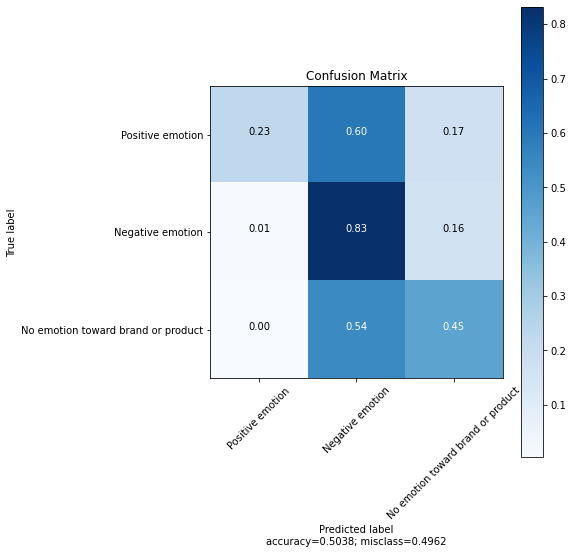

In [141]:
evaluate_model(y_test_arr,y_hat_test,X_test_tfidf,rf)

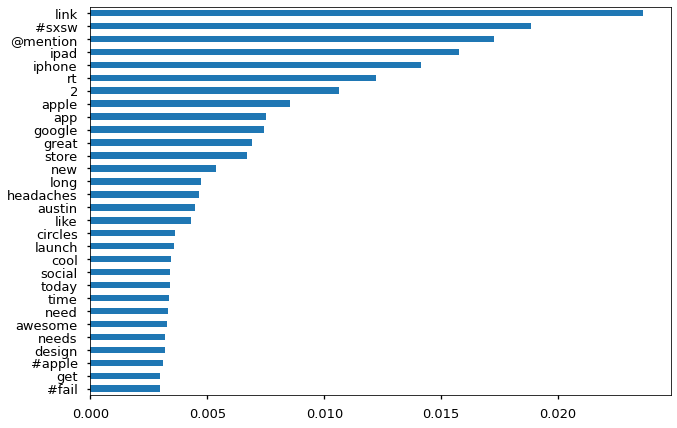

In [142]:
with plt.style.context('seaborn-talk'):

    ## Get Feature Importance
    importance = pd.Series(rf.feature_importances_,index=vectorizer.get_feature_names())

    ## Sort values 


    ## Take the .tail 30 and plot kind='barh'
    importance.sort_values().tail(30).plot(kind='barh')


# GridSearch with Pipelines

The reason we're bothering with pipelines is to make sure we can build a grid search that will help us produce the best random forest model. So below we'll get into that and hopefully should see a better performing model.

In [143]:
# X_train_pipe, y_train.shape

In [158]:
# from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
# from imblearn.over_sampling import SMOTE
# from sklearn.pipeline import Pipeline

# from sklearn import set_config
# set_config(display='text')
# count_vect = CountVectorizer(tokenizer=tokenizer.tokenize,
#                             stop_words=stopwords_ls)
# tf_transform = TfidfTransformer(use_idf=True)

# text_pipe = Pipeline(steps=[
#     ('count_vectorizer',count_vect),
#     ('tf_transformer',tf_transform)])

# full_pipe = Pipeline(steps=[('text_pipe',text_pipe),
#     ('clf',RandomForestClassifier())
# ])

# X_train_pipe = text_pipe.fit_transform(X_train).todense()
# X_test_pipe = text_pipe.transform(X_test).todense()


In [160]:
# sm = SMOTE()

# X_train_smote, y_train_smote = sm.fit_resample(X_train_pipe, y_train)

# params = {'criterion':['gini', 'entropy']}

# # params = { 'clf__criterion':['gini', 'entropy']}
# grid = GridSearchCV(RandomForestClassifier(),params,cv=5,scoring = 'recall_macro')
# print(grid)
# grid.fit(X_train_smote, y_train_smote)
# ## Best parameters
# grid.best_params_


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy']},
             scoring='recall_macro')


{'criterion': 'entropy'}

In [158]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline

from sklearn import set_config
set_config(display='text')
count_vect = CountVectorizer(tokenizer=tokenizer.tokenize,
                            stop_words=stopwords_ls)
tf_transform = TfidfTransformer(use_idf=True)

text_pipe = Pipeline(steps=[
    ('count_vectorizer',count_vect),
    ('tf_transformer',tf_transform)])

full_pipe = Pipeline(steps=[('text_pipe',text_pipe),
    ('clf',RandomForestClassifier())
])

X_train_pipe = text_pipe.fit_transform(X_train).todense()
X_test_pipe = text_pipe.transform(X_test).todense()


In [172]:
sm = SMOTE()

X_train_smote, y_train_smote = sm.fit_resample(X_train_pipe, y_train)

params = {'criterion':['gini', 'entropy']}

# params = { 'clf__criterion':['gini', 'entropy']}
grid = GridSearchCV(RandomForestClassifier(class_weight='balanced'),params,cv=5,scoring = 'recall_macro')
print(grid)
grid.fit(X_train_smote, y_train_smote)
## Best parameters
grid.best_params_


GridSearchCV(cv=5, estimator=RandomForestClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy']},
             scoring='recall_macro')


{'criterion': 'entropy'}

In [173]:
grid.estimator

RandomForestClassifier(class_weight='balanced')

In [174]:
from sklearn import set_config
set_config(display='text')

full_pipe

Pipeline(steps=[('text_pipe',
                 Pipeline(steps=[('count_vectorizer',
                                  CountVectorizer(stop_words=['i', 'me', 'my',
                                                              'myself', 'we',
                                                              'our', 'ours',
                                                              'ourselves',
                                                              'you', "you're",
                                                              "you've",
                                                              "you'll", "you'd",
                                                              'your', 'yours',
                                                              'yourself',
                                                              'yourselves',
                                                              'he', 'him',
                                                              'his', 'h

In [175]:
best_pipe = grid.best_estimator_
print(best_pipe)
y_hat_test = grid.predict(X_test_pipe)

RandomForestClassifier(class_weight='balanced', criterion='entropy')


In [176]:
features = full_pipe.named_steps['text_pipe'].named_steps['count_vectorizer'].get_feature_names()

In [177]:
## Check matplot lib post 3.3 update need to have

                                    precision    recall  f1-score   support

                  Positive emotion       0.69      0.23      0.34       168
                  Negative emotion       0.68      0.84      0.75      1598
No emotion toward brand or product       0.61      0.43      0.50       915

                          accuracy                           0.66      2681
                         macro avg       0.66      0.50      0.53      2681
                      weighted avg       0.66      0.66      0.64      2681



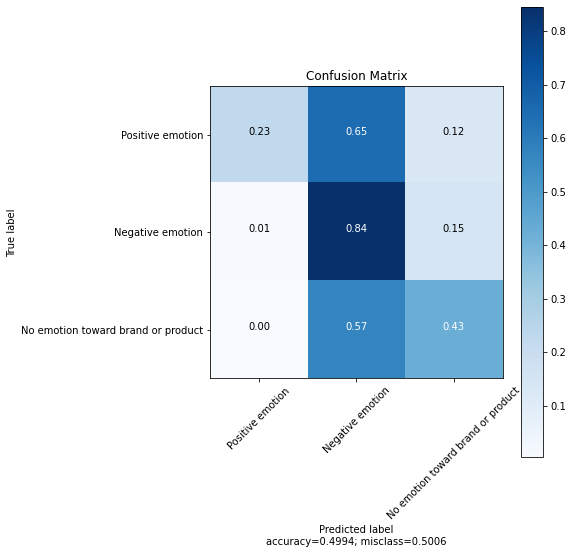

In [178]:
evaluate_model(y_test_arr,y_hat_test,X_test_pipe,best_pipe)

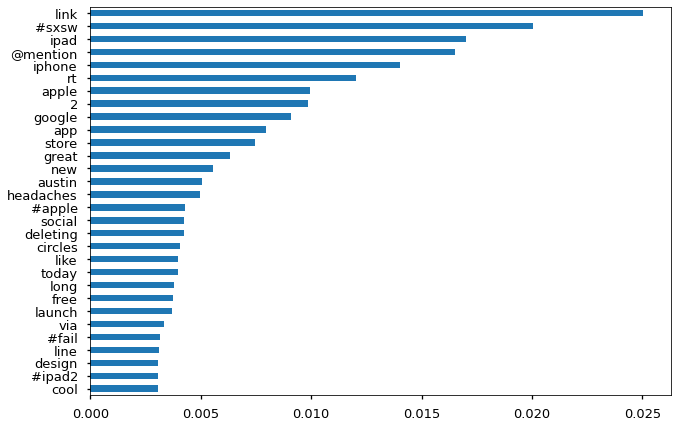

In [167]:
rf = best_pipe
# .named_steps['clf']
with plt.style.context('seaborn-talk'):
    importance = pd.Series(rf.feature_importances_,index= features)#vectorizer.get_feature_names())
    importance.sort_values(inplace=True)

    importance.sort_values().tail(30).plot(kind='barh')

### Important words and where they showed up in emotions

What I want to look at next is the where these words appeared most, based on each sentiment. Below we're going to try and achieve that.

In [168]:
top_word_probs = {}
for word in importance.tail(30).index:
    rows = df['tweet'].str.contains(word,regex=False,case=False)
    val_count= df[rows]['emotions_cat'].value_counts(normalize=True)
    top_word_probs[word] = val_count

In [169]:
top_probs = pd.DataFrame(top_word_probs).T
top_probs.style.background_gradient(axis=1)

## Fix x axis labels revert back to categorical names

,0,1,2
cool,0.029586,0.183432,0.786982
#ipad2,0.027211,0.530612,0.442177
design,0.121212,0.632035,0.246753
line,0.045833,0.635417,0.318750
#fail,0.523810,0.333333,0.142857
via,0.032634,0.652681,0.314685
launch,0.035409,0.728938,0.235653
free,0.005391,0.684636,0.309973
long,0.177570,0.570093,0.252336
today,0.036778,0.767075,0.196147


## Real-time test with model

In [170]:
from sklearn.feature_extraction.text import TfidfTransformer
test_tweet = ["Headaches",
              'brutal',
              'this is incredible, i love it so much',
              'kill me now',
             'apple is the worst product I have ever purchased',
             'I do not want to buy any more products',
             'I want to buy everything in this store, it is all so incredible and amazing and wonderful']
X_new_counts = count_vect.transform(test_tweet)
X_new_tfidf = tf_transform.transform(X_new_counts)
predicted = rf.predict(X_new_tfidf)

In [171]:
for doc in zip(test_tweet, predicted):
    print('%r => %s' % (doc))

'Headaches' => 1
'brutal' => 1
'this is incredible, i love it so much' => 1
'kill me now' => 1
'apple is the worst product I have ever purchased' => 1
'I do not want to buy any more products' => 1
'I want to buy everything in this store, it is all so incredible and amazing and wonderful' => 1


## Conclusion

Following the exploration of the dataset we can conclude on a few things. That our model performed well and it performed well when it came to the recall of negative emotions. Which in this instance we want to be more sensitive towards. It speaks to itself, but a company would rather hear more about negative comments than positive so they can improve their business.

There are some obvious words that associate with negative emotion, like 'sucks' but the runner ups were words like 'design'. From a client perspective, you'd want to dig more into the underlying problems with design and maybe single out tweets that included design and were negative. This way a business can tweak where things went wrong for the consumer.


We can recommend to anyone looking to leverage a model like the above is to exlore the patterns you normally see with your consumer base. Is it always positive, is it always negative or is it neutral. From here you can really slice and dice the model the perform in a way that would allow you to take a deeper dive into your consumer base. For the context of this model it will help pull / identify negative tweets for the client.